# Comparing Optimization Results using Active Subspaces and Derivative-Free Optimization on a Function with Additive Noise

In [1]:
# Import needed packages

import active_subspaces as ac
import numpy as np
import matplotlib.pyplot as plt

# Introduction

The function we use for demonstration is:

$$f: \mathbb{R}^{16} \to \mathbb{R}$$

$$f: \vec{x} \to f(\vec{x})$$

$$
f(\vec{x})=f((x_1,x_2,x_3,x_4,x_5,x_6,x_7,\ldots,x_{16})) = \alpha (x_1+x_2)^2+\beta (x_3+x_4)^2+\gamma (x_5+x_6)^2
$$

Notice we have defined $f$ to have no depedence on \{$x_7,\ldots,x_{16}$\}; to model those parameters as useless predictors, we will add a random noise factor $\epsilon$ to all function outputs, so that $$\texttt{pert_f}:=\tilde{f}(\vec{x})=f(\vec{x})+\epsilon.$$ The random noise factor $\epsilon$ is scaled to the unperturbed function output; in particular, we'll let $\epsilon \propto \left|\left|f(\vec{x})\right|\right|$.

We will explore what happens when $\alpha>\beta>\gamma$, with a relatively small additive random noise factor. This is a regime under which active subspace analysis is well-suited. Indeed, since the term $\alpha(x_1+x_2)$ contributes most to function outputs, the active subspace emerges as a linear combination $\eta^T\begin{bmatrix}
x_1\\
x_2\\
\end{bmatrix},$ where $\eta \in \mathbb{R}^2$. The components of $\eta$ are given by components in the eigenvectors computed either through Principal Component Analysis in gradient space (Russi) or through Active Subspace analysis (Constantine). In fact, $\eta$ is a normalized eigenvector. Since $x_1$ and $x_2$ are equally important with respect to function value contributions and $x_3,x_4,\ldots,x_{16}$ are unimportant with respect to function values, we expect the components of $\eta$ to converge to the vector $\left(\frac{1}{\sqrt{2}},\frac{1}{\sqrt{2}},0,\ldots,0\right)^T$ as iterations $k$ tend to infinity. To compare this analysis to the DF framework, we will not use an analytical gradient; instead, we can recycle the function evaluations from the DF algorithm to form our sample matrix in AS analysis, and to form a locally linear approximation to $\nabla f$.

We assume each variable has an a priori distribution of U[-1,1] to avoid normalization. We note this is a standard interval that we normalize to anyway (see Russi, Constantine). For the purpose of understand Active Subspace analysis, we first perform $M=1000$ random draws on the hypercube $\Lambda:=[-1,1]^{16}$ and form the $M \times 16$ "input matrix" $A$ by transposing each sample into a $1\times 16$ row vector and stacking them into a matrix; this allows us to compute the active subspace so that we can check the accuracy of active subspace approximations when we use significantly less function evaluations later in the notebook. The matrix $A$ is denoted with a lower $\texttt{a}$ in the notebook.

In [2]:
# Number of samples for active subspace computation
M = 1000

# The input matrix
a = np.random.uniform(low=-1, high=1, size=(M,16))

# Parameters alpha, beta, gamma from our function
A = 1000 # alpha
B = 10 # beta
C = 1 # gamma

# An M x 1 column vector containing the evaluations of f at data points 1,...,M
def fun(a):
    
    a = a.copy()
    a = np.atleast_2d(a)
    M = a.shape[0]
    
    x = a[:,0]; y = a[:,1]; z = a[:,2]; w = a[:,3]; p = a[:,4]; q = a[:,5]; 
    
    return (A*(x+y)**2+B*(z+w)**2+C*(p+q)**2+9).reshape(M, 1)

def gun(a):
    
    a = a.copy()
    a = np.atleast_2d(a)
    M = a.shape[0]
    
    x = a[:,0]; y = a[:,1]; z = a[:,2]; w = a[:,3]; p = a[:,4]; q = a[:,5]; 
    
    return (A*np.sin(x+y)**2+(A/2)*np.sin(z+w)**2+C*p**2).reshape(M, 1)

def hun(a):
    
    a = a.copy()
    a = np.atleast_2d(a)
    M = a.shape[0]
    
    x = a[:,0]; y = a[:,1]; z = a[:,2]; w = a[:,3]; p = a[:,4]; q = a[:,5]; 
    
    return (A*(x**2+y)+2*B*(z+w)**100+C*(p+q+x**3)**2).reshape(M, 1)

f=fun(a)
g=gun(a)

# Global noise proportionality constant
k = 1e-6

# Perturbed function output
pert_f=g+np.linalg.norm(g)*k*(2*(np.random.rand(M,1))-np.ones((M,1)))

# Computation of the Active Subspace

For AS analysis, we mimic Paul Constantine's "basic" tutorial in his active subspaces library on GitHub, using a different toy function. All text directly copied from Paul's original notebook are cited with quotations throughout this notebook. Let $A_k$ denote the $k$-th row of $A$, which is the $k$-th of our $M$ samples of vectors in $[-1,1]^{16}$. 

We form a local linear approximation to the $\nabla \tilde{f}$, which we denote $\tilde{\nabla f}$. We evaluate the approximation at all $M$ samples, giving us $M$ $16 \times 1$ column vectors, $\tilde{\nabla f}(A_k^T)$, $k=1,\ldots,M$. Finally, we form the $M \times 16$ matrix

$$\texttt{noisy_grad_fun(a)}:=\texttt{grad_fun(a)}+E=\begin{bmatrix}
\tilde{\nabla f}(A_1^T)^T\\
\cdot \cdot \cdot\\
\tilde{\nabla f}(A_k^T)^T\\
\cdot \cdot \cdot \\
\tilde{\nabla f}(A_M^T)^T\\
\end{bmatrix}.$$

In order to "see" the important linear combinations in $\Lambda$, we print out the first of the eigenvectors formed in the AS analysis.

/home/students/halljord/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


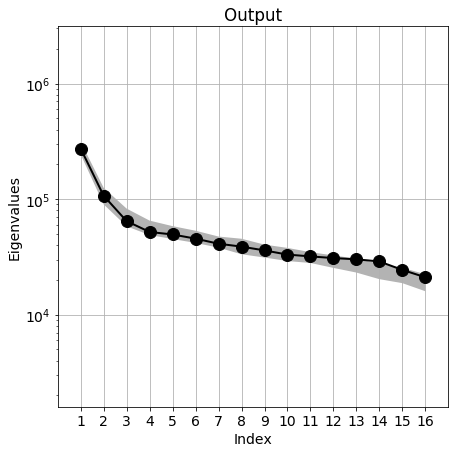

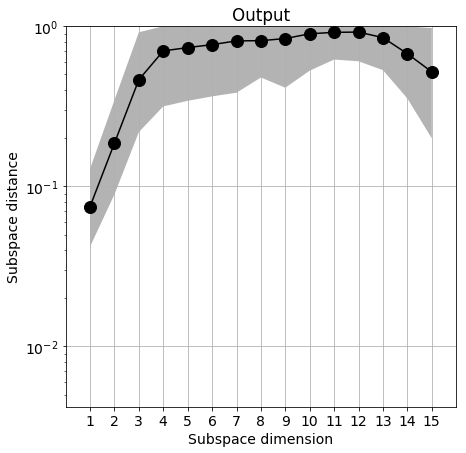

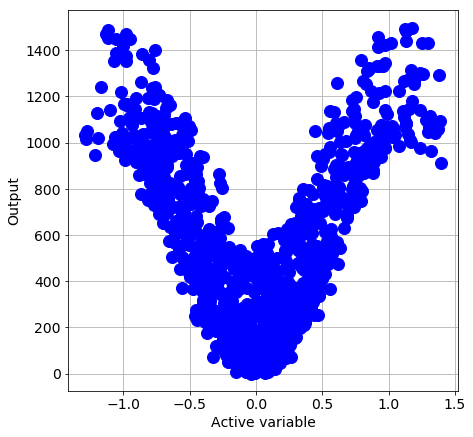

[ 0.70689471  0.69948462 -0.04444277 -0.02437775 -0.02507486 -0.00776524
  0.03968421 -0.02276928 -0.00122815  0.04416378  0.02165678  0.00961148
  0.04056018  0.01688912 -0.00377449  0.03480538]
(16,)
[ 0.70689471  0.69948462 -0.04444277 -0.02437775 -0.02507486 -0.00776524
  0.03968421 -0.02276928 -0.00122815  0.04416378  0.02165678  0.00961148
  0.04056018  0.01688912 -0.00377449  0.03480538]


In [3]:
# USING LOCAL LINEAR APPROXIMATIONS TO GRAD(F)

#Instantiate a subspace object
ss = ac.subspaces.Subspaces()

df = ac.gradients.local_linear_gradients(a, pert_f) #Estimated gradients using local linear models

ss.compute(df=df, nboot=100)
ac.utils.plotters.eigenvalues(ss.eigenvals, ss.e_br)
ac.utils.plotters.subspace_errors(ss.sub_br)
ac.utils.plotters.sufficient_summary(a.dot(ss.W1), pert_f)

print(ss.W1[:,0])
print(np.shape(ss.W1[:,0]))
print(ss.eigenvecs[:,0])

# Fitting a Polynomial Surrogate

The R^2 value of the response surface is 0.7775


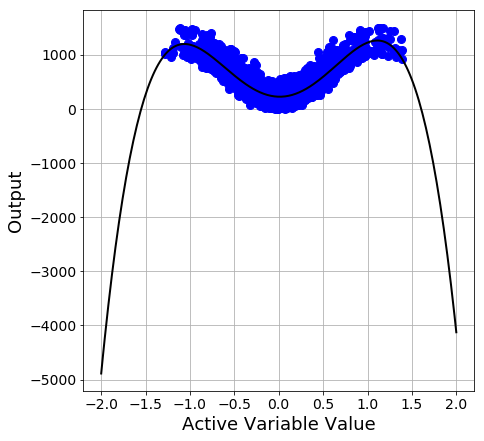

In [4]:
#quadratic polynomial approximation
RS = ac.utils.response_surfaces.PolynomialApproximation(4)

#Train the surface with active variable values (y = a.dot(ss.W1)) and perturbed function values (f)
y = a.dot(ss.W1)
RS.train(y, pert_f)
print 'The R^2 value of the response surface is {:.4f}'.format(RS.Rsqr)

#Plot the data and response surface prediction
plt.figure(figsize=(7, 7))
y0 = np.linspace(-2, 2, 200)
plt.plot(y, pert_f, 'bo', y0, RS.predict(y0[:,None])[0], 'k-', linewidth=2, markersize=8)
plt.grid(True)
plt.xlabel('Active Variable Value', fontsize=18)
plt.ylabel('Output', fontsize=18)
plt.show()

# Minimize the Surrogate

In [5]:
#Minimize using the response surface

avdom = ac.domains.BoundedActiveVariableDomain(ss)
avmap = ac.domains.BoundedActiveVariableMap(avdom)
ystar, fstar = ac.optimizers.av_minimize(lambda x: RS.predict(x.reshape(1,1))[0], avdom) # had to change (1,1) to (1,3)
print 'The response surface optimization results are\n: ystar = {:.4f}, fstar = {:.4f}\n'.\
    format(ystar[0,0], fstar[0,0])


The response surface optimization results are
: ystar = 0.0110, fstar = 221.2601



# Build STAR function

In [6]:
def STARS(x_init,F,mu_star,h,k,maxit):
    
    #x_init: initial x value
    #F: function we wish to minimize
    #note that lower f's are evaluations of F(*)
    #mu_star: smoothing parameter
    #h: step length
    #k: noise parameter
    #maxit: maximum number of iterations
    
    x=x_init
    
    #Evaluate F(x_init)
    f=F(x_init) + k*(2*np.random.rand(1)-1)
    
    x_hist=np.array(x)
    f_hist=np.array(f)
    
    for i in range(1, maxit):
        u=np.random.normal(0,1,np.size(x_init))
    
        err=k*(2*np.random.rand(1) -1)
    
        y=x+(mu_star)*u
        x_hist=np.vstack((x_hist,y))
    
        g=F(y) + err
        f_hist=np.vstack((f_hist,g))
    
        s=((g - f)/mu_star)*u 
    
        x=x - (h)*s
        x_hist=np.vstack((x_hist,x))
    
        err=k*(2*np.random.rand(1) -1)
    
        f=F(x) + err
        f_hist=np.vstack((f_hist,f))
        
    return x, f

In [11]:
def function1(a):
    a=a[0]
    x = a[0]; y = a[1]; z = a[2]; w = a[3]; p = a[4]; q = a[5]; 
    
    return (A*(x+y)**2+B*(z+w)**2+C*(p+q)**2+9)

def function2(a):
    a=a[0]
    x = a[0]; y = a[1]; z = a[2]; w = a[3]; p = a[4]; q = a[5]; 
    
    return (A*np.sin(x+y)**2+(A/2)*np.sin(z+w)**2+C*p**2)
            
x_test=2*np.random.rand(1,16)-np.ones(16)

print(function1(x_test))
print(function2(x_test))

1048.74743532
795.521888068


In [12]:
x_init=2*np.random.rand(1,16)-np.ones(16)
F=function1
mu_star=2e-4
h=3.9e-5
k=1e-4
maxit=1000

STARS(x_init,F,mu_star,h,k,maxit)

(array([[-0.50098521,  0.50166213, -0.17824776,  0.32245359, -0.75084791,
         -0.88140202, -0.03179248,  0.38955275, -0.85756334, -0.7404553 ,
         -0.41353806,  0.27295881, -0.4777319 , -0.30150045, -1.11610303,
         -0.03535712]]), array([ 11.87256723]))

# Derivative-Free Optimization using STARS Algorithm by Chen and Wild #

## Algorithm 0

### Pure STARS

In [33]:
# Initialize #


# Choose initial point and compute initial noisy function evaluation
x=2*np.random.rand(1,16)-np.ones(16)
print(np.shape(x))
print(x)
start=x

f=gun(x)[0,0] + np.linalg.norm(g)*k*(2*np.random.rand(1,1)-1)

F=k*np.linalg.norm(f)


# Smoothing parameter
mu_star=2e-4


# Step length
h=3.9e-5


# Have a look
print(f)
print(k)
print(F)
np.size(x)

(1, 16)
[[ 0.70872712  0.67271467 -0.74839643 -0.78609357  0.89561854 -0.09103663
   0.47705948  0.21072104  0.59490957 -0.33771003 -0.58092112  0.77369971
   0.27811514 -0.79209197  0.09409369 -0.31697684]]
[[ 1464.71469106]]
1e-06
0.00146471469106


16

In [7]:
# STARS Algorithm #

x_hist=np.array(x)
f_hist=np.array(f)

maxit=1000

for i in range(1, maxit):
    u=np.random.normal(0,1,16)
    
    err=F*(2*np.random.rand(1,1) -1)
    
    y=x+(mu_star)*u
    #x_hist=np.vstack((x_hist,y))
    
    g=gun(y)[0,0] + err
    #f_hist=np.vstack((f_hist,g))
    
    s=((g - f)/mu_star)*u 
    
    x=x - (h)*s
    x_hist=np.vstack((x_hist,x))
    
    err=F*(2*np.random.rand(1,1) -1)
    
    f=gun(x)[0,0] + err
    f_hist=np.vstack((f_hist,f))
    
print(x)    
print(f)
print(np.linalg.norm(x))

[[ 1.4564625   1.6841222  -1.82750521 -1.31487513  0.3506454  -0.1751145
  -1.02102633  0.08246888  0.14942938  0.64049209 -0.52922539 -0.40920078
   0.03957947  0.59997705 -0.96491302  0.17648004]]
[[ 0.12537019]]
3.66510041541


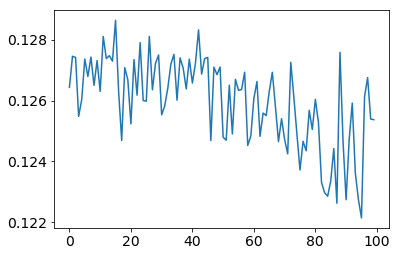

In [17]:

plt.plot(f_hist[900:])
plt.show()

# Use STARS and Active Subspace Analysis Together

## Algorithm 1

### Using the Active Subspace already computed above
### Run STARS maxit times, then project iterate into the already-computed A.S.
### Repeat this Maxit times

In [26]:
# Initialize #


# Choose initial point and compute initial noisy function evaluation
#x=2*np.random.rand(1,16)-np.ones(16)
x=start
print(np.shape(x))
print(x)

f=gun(x)[0,0] + np.linalg.norm(g)*k*(2*np.random.rand(1,1)-1)

F=k*np.linalg.norm(f)


# Smoothing parameter
mu_star=2e-4


# Step length
h=3.9e-5


# Have a look
print(f)
print(k)
print(F)

(1, 16)
[[ 0.90292471  0.75466141 -0.92474335 -0.78562276  0.51311144 -0.75169715
  -0.73859566 -0.21978266  0.11580684  0.94018037 -0.59348774 -0.81458633
   0.37178882  0.60450766 -0.94107658  0.07493313]]
[[ 1483.07292654]]
1e-06
0.00148307292654


In [27]:
# Iterate both STARS and AS in tandem

# This algorithm assumes AS has already been computed

# We run STARS maxit times, project the resulting iterate into the AS, and repeat.

f_hist=np.array(f)

# Set iteration counters
maxit=500
Maxit=20

for i in range(1,Maxit):
    
    # STARS
    
    for i in range(1, maxit):
        u=np.random.normal(0,1,16) #random step for STARS
    
        err=F*(2*np.random.rand(1,1) -1) #additive noise for function
        
        g=gun(x+(mu_star)*u)[0,0] + err
    
        s=((g - f)/mu_star)*u 
    
        x=x - (h)*s
        
        err=F*(2*np.random.rand(1,1) -1)
        
        f=gun(x)[0,0] + err
        f_hist=np.vstack((f_hist,f))
    
    # Project the new x value into the active subspace ss.W1
    
    x=(x.reshape((1, 16)).dot(ss.W1))*ss.W1
    x=x.reshape(1,16)
    
    err=F*(2*np.random.rand(1,1) -1)
    
    f=gun(x)[0,0] + err

print(x)    
print(f)
print(np.linalg.norm(x))

[[ 1.58563963  1.5546747   0.07203378  0.05158619  0.13537928 -0.12428994
   0.02331472  0.00161385 -0.10508356 -0.00377102 -0.07992588 -0.06713625
  -0.0213743  -0.05574531 -0.05332732 -0.08866175]]
[[ 7.62232467]]
2.23822685851


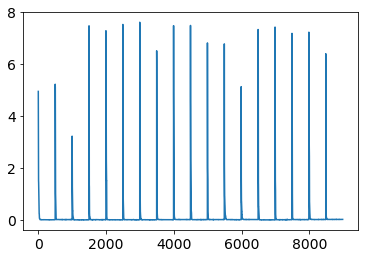

In [28]:

plt.plot(f_hist[500:])
plt.show()

## Algorithm 2

### Using the Active Subspace already computed above
### Run STARS maxit times, then moves iterates into the direction of the already-computed A.S.
### Repeat this Maxit times

In [40]:
# Initialize #


# Choose initial point and compute initial noisy function evaluation
x=2*np.random.rand(1,16)-np.ones(16)
print(np.shape(x))
print(x)

f=fun(x)[0,0] + np.linalg.norm(f)*k*(2*np.random.rand(1,1)-1)

F=k*np.linalg.norm(f)


# Smoothing parameter
mu_star=2e-3


# Step length
h=3.9e-4


# Have a look
print(f)
print(k)
print(F)

(1, 16)
[[ 0.09676458  0.09554869  0.59595953 -0.11459709  0.90940066 -0.60248724
  -0.59833292 -0.11384172  0.17820495 -0.01262369  0.43672543 -0.9711705
  -0.66411943 -0.36376876 -0.92097413 -0.93444522]]
[[48.39450381]]
1e-06
4.839450380808981e-05


In [41]:
# This algorithm assumes AS has already been computed

# We run STARS maxit times.
# Instead of projecting the iterate, we instead only let the random vector u
# step in the direction of the AS. This is done by only drawing a scalar value off of N(0,1)
# and using it as the coefficient to the vector "sub," the first principal vector computed from the AS

# Set Maximum iteration counter for outside for loop
Maxit=20000

# We initialize the random vector u==ss.W1, the eigenvector from A.S. calculation above
# Warning: Right now this is just one vector; could be several of them with a different f

sub=ss.W1[:,0]

#sub=np.random.normal(0,1,16)

print(sub)
print(np.shape(sub))
print(x+sub)

[ 7.00721976e-01  7.05388597e-01  2.08464768e-02 -1.22416001e-02
 -1.25094109e-02  4.41734414e-04 -1.64182519e-02 -1.68305149e-02
 -7.60276981e-02 -2.55906212e-03 -1.90881332e-02  2.66882784e-02
  1.30061541e-02  5.36760617e-02 -1.24732296e-02  7.24286288e-03]
(16,)
[[ 0.79748655  0.80093729  0.616806   -0.12683869  0.89689125 -0.6020455
  -0.61475117 -0.13067224  0.10217725 -0.01518275  0.41763729 -0.94448222
  -0.65111327 -0.3100927  -0.93344736 -0.92720236]]


In [42]:
for i in range(1,Maxit):
    
    sclr=np.random.normal(0,1) #random step (now just a scalar) for STARS -- normal or unif????
    #sclr=2*np.random.rand(1,1)-1
        
    u=sclr*sub
        
    err=F*(2*np.random.rand(1,1) -1) #additive noise for function
        
    g=fun(x+(mu_star)*u)[0,0] + err
    
    s=((g - f)/mu_star)*u 
    
    x=x - (h)*s
    
    err=F*(2*np.random.rand(1,1) -1)
    
    f=fun(x)[0,0] + err
        
print(np.shape(x))
print(x)
print(f)
print(np.linalg.norm(x))
#print(x.reshape((1, 16)).dot(sub)*sub)

(1, 16)
[[ 1.17347494e-03 -6.79016940e-04  5.93115691e-01 -1.12927116e-01
   9.11107172e-01 -6.02547496e-01 -5.96093170e-01 -1.11545738e-01
   1.88576496e-01 -1.22745837e-02  4.39329392e-01 -9.74811258e-01
  -6.65893703e-01 -3.71091144e-01 -9.19272556e-01 -9.35433280e-01]]
[[11.40123107]]
2.3250138611187023


## Algorithm 3

### Learns Active Subspace by storage of all $x$ and $f(x)$ values
### Run STARS maxit times, compute A.S. using data, project current iterate into A.S.
### Repeat this Maxit times

In [43]:
# Initialize #


# Choose initial point and compute initial noisy function evaluation
x=2*np.random.rand(1,16)-np.ones(16)
print(np.shape(x))
print(x)

f=fun(x)[0,0] + np.linalg.norm(f)*k*(2*np.random.rand(1,1)-1)

F=k*np.linalg.norm(f)


# Smoothing parameter
mu_star=2e-4


# Step length
h=3.9e-5


# Have a look
print(f)
print(k)
print(F)

(1, 16)
[[ 0.28330602  0.29776522 -0.5226332   0.85155929  0.76355195  0.17055469
  -0.52412289  0.32179176 -0.05838409  0.94868537 -0.1748469  -0.51083808
  -0.27047478 -0.50609042  0.12208232  0.52344596]]
[[348.59825544]]
1e-06
0.00034859825544312107


In [44]:
# This algorithm assumes AS has NOT already been computed

# We run STARS maxit times, compute AS with those f values, project current iterate x_k into the AS, and repeat.

# For more exploratory x and f(x) values, we have optional random draws in [-1,1] with each STARS iteration

# Set Maximum iteration counters
maxit=200
Maxit=10
x_hist=np.array(x)
f_hist=np.array(f)


for i in range(1,Maxit):
    
    # STARS
    
    for i in range(1, maxit):
        u=np.random.normal(0,1,16) #random step for STARS
    
        err=F*(2*np.random.rand(1,1) -1) #additive noise for function
        
        y=x+(mu_star)*u
        x_hist=np.vstack((x_hist,y))
        
        g=fun(y)[0,0] + err
        f_hist=np.vstack((f_hist,g))
    
        s=((g - f)/mu_star)*u 
    
        x=x - (h)*s 
        x_hist=np.vstack((x_hist,x))
        
        err=F*(2*np.random.rand(1,1) -1)
    
        f=fun(x)[0,0] + err
        f_hist=np.vstack((f_hist,f))
        
        # Exploratory x values, definitely cheating if f is expensive.
        #expval=2*np.random.rand(1,16)-np.ones(16)
        #fexpval=fun(expval)[0,0] + err
        
        #x_hist=np.vstack((x_hist,expval))
        #f_hist=np.vstack((f_hist,fexpval))
    
    # Compute AS using function values stored in f_hist
    
    # Instantiate a subspace object
    ss = ac.subspaces.Subspaces()

    # Use Local Linears
    #df = ac.gradients.local_linear_gradients(x_hist, f_hist) #Estimated gradients using local linear models
    #ss.compute(df=df, nboot=0)
    
    # Use Global Quadratic
    ss.compute(X=x_hist, f=f_hist, nboot=0, sstype='QPHD')

    
    
    sub=ss.eigenvecs[:,0]

    
    
    # Project the new x value into the active subspace ss.W1
    
    x=(x.reshape((1, 16)).dot(sub))*sub
    x=x.reshape(1,16)
    x_hist=np.vstack((x_hist,x))
    
    err=F*(2*np.random.rand(1,1) -1)
    
    f=fun(x)[0,0] + err
    f_hist=np.vstack((f_hist,f))

print(x)    
print(f)
print(np.shape(f_hist))
print(np.linalg.norm(x))
print(sub)
print(np.linalg.norm(sub))

[[ 2.83760876e-04  2.85339187e-04 -1.89456864e-08 -4.39689055e-07
  -1.10231464e-06  1.31952229e-06  2.11972951e-06  8.72309343e-07
  -1.40857514e-06 -4.92649315e-07  1.42290884e-06 -1.48736175e-06
   8.49660476e-07 -6.10426728e-07  1.17288303e-07  1.63439459e-06]]
[[9.00032732]]
(3592, 1)
0.00040243922947663896
[ 7.05102423e-01  7.09024284e-01 -4.70771361e-05 -1.09256013e-03
 -2.73908347e-03  3.27881128e-03  5.26720397e-03  2.16755544e-03
 -3.50009401e-03 -1.22415828e-03  3.53571108e-03 -3.69586670e-03
  2.11127647e-03 -1.51681716e-03  2.91443514e-04  4.06122085e-03]
1.0


## Algorithm 4

### Learns Active Subspace by storage of all $x$ and $f(x)$ values
### Run STARS maxit times, compute A.S. using data, moves iterates in direction of A.S.
### Repeat this Maxit times

In [49]:
# Initialize #


# Choose initial point and compute initial noisy function evaluation
x=2*np.random.rand(1,16)-np.ones(16)
print(np.shape(x))
print(x)

f=fun(x)[0,0] + np.linalg.norm(f)*k*(2*np.random.rand(1,1)-1)

F=k*np.linalg.norm(f)


# Smoothing parameter
mu_star=2e-3


# Step length
h=3.9e-4


# Have a look
print(f)
print(k)
print(F)

(1, 16)
[[-0.47155602 -0.76381725  0.61323741 -0.70882891  0.30827075  0.52363295
  -0.31306738 -0.21862442 -0.45314139  0.7007247  -0.62307272 -0.62642014
   0.25880846  0.87095737 -0.98946388  0.28909236]]
[[1535.94256389]]
1e-06
0.0015359425638863866


In [50]:
# This algorithm assumes AS has NOT already been computed

# We run STARS maxit times, compute AS with those f values.

# Instead of projecting the iterate, we instead only let the random vector u
# step in the direction of the AS. This is done by only drawing a scalar value off of N(0,1)
# and using it as the coefficient to the vector "sub," the first principal vector computed from the AS

# For more exploratory x and f(x) values, we have optional random draws in [-1,1] with each STARS iteration

# Set Maximum iteration counter for outside for loop
maxit=200
Maxit=10
x_hist=np.array(x)
f_hist=np.array(f)

# We initialize the random vector u==sub, since we don't know the AS yet
sub=np.random.normal(0,1,16)

for i in range(1,Maxit):
    
    # STARS
    
    for i in range(1, maxit):
        sclr=np.random.normal(0,1) #random step (now just a scalar) for STARS -- unif or normal???
        #sclr=2*np.random.rand(1,1)-1
        
        u=sclr*sub
        
        err=F*(2*np.random.rand(1,1) -1) #additive noise for function
        
        y=x+(mu_star)*u
        x_hist=np.vstack((x_hist,x))
        
        g=fun(y)[0,0] + err
        f_hist=np.vstack((f_hist,g))
    
        s=((g - f)/mu_star)*u 
    
        x=x - (h)*s 
        x_hist=np.vstack((x_hist,x))
        
        err=F*(2*np.random.rand(1,1) -1)
        
        f=fun(x)[0,0] + err
        f_hist=np.vstack((f_hist,f))
        
    
    # Compute AS using function values stored in f_hist
    
    # Instantiate a subspace object
    ss = ac.subspaces.Subspaces()

    # Use Local Linears
    #df = ac.gradients.local_linear_gradients(x_hist, f_hist) #Estimated gradients using local linear models
    #ss.compute(df=df, nboot=0)
    
    # Use Global Quadratic
    ss.compute(X=x_hist, f=f_hist, nboot=0, sstype='QPHD')

    
    
    sub=ss.eigenvecs[:,0]
    
print(x)    
print(f)
print(np.linalg.norm(x))
print(sub)
print(x_hist.shape)
print(f_hist.shape)

[[ 1.65648797 -1.6439814  -0.15676672  0.49422538  1.60850477  1.75745738
   1.10704389 -0.58763255 -1.82580765  2.22260376  2.21831634  1.39556212
   2.40185262  2.65418966 -0.28508847  0.45169441]]
[[21.62408239]]
6.4189756283280275
[ 0.16076597 -0.24559128 -0.00944414  0.02231862  0.26969169  0.30572879
  0.19435496 -0.10410646 -0.29846073  0.3063007   0.32895374  0.15787029
  0.35594643  0.49861039 -0.05367754  0.06490172]
(3583, 16)
(3583, 1)


In [51]:
### Algo. 5

In [58]:
# Initialize #


# Choose initial point and compute initial noisy function evaluation
x=2*np.random.rand(1,16)-np.ones(16)
print(np.shape(x))
print(x)

f=fun(x)[0,0] + np.linalg.norm(f)*k*(2*np.random.rand(1,1)-1)

F=k*np.linalg.norm(f)


# Smoothing parameter
mu_star=2e-3


# Step length
h=3.9e-5


# Have a look
print(f)
print(k)
print(F)

(1, 16)
[[ 0.03196885  0.13510409 -0.43521391  0.72246021 -0.54015644  0.47384622
  -0.60873428  0.7646296   0.94719299  0.7907885   0.18238999  0.95026946
   0.80291642 -0.53433375 -0.14128336 -0.52126485]]
[[37.74286077]]
1e-06
3.774286076688806e-05


[[ 5.47870979e-04  5.48095459e-04 -1.45408506e-06  1.38370223e-07
  -4.27375526e-07 -1.28937112e-06 -3.51292899e-07 -1.19319377e-06
   1.98498438e-07 -1.17670346e-06 -5.51439705e-07  2.05004153e-07
   1.07312124e-06  5.97678645e-07  3.26894830e-07  6.79634822e-07]]
[[9.00120889]]
(200, 1)
0.0007749713645858626
[ 7.06956417e-01  7.07246079e-01 -1.87630811e-03  1.78548820e-04
 -5.51472668e-04 -1.66376614e-03 -4.53297909e-04 -1.53966175e-03
  2.56136481e-04 -1.51838314e-03 -7.11561394e-04  2.64531262e-04
  1.38472373e-03  7.71226748e-04  4.21815366e-04  8.76980561e-04]
1.0000000000000002


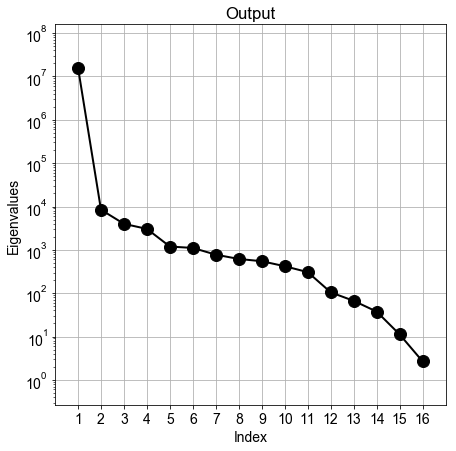

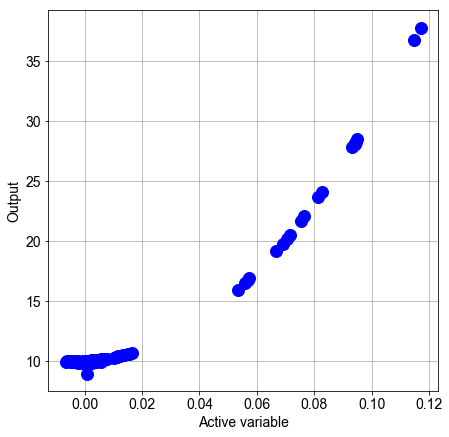

In [59]:
# This algorithm assumes AS has NOT already been computed

# STARS burn-in followed by active subspace calculation

# Set Maximum iteration counters
Maxit=100
x_hist=np.array(x)
f_hist=np.array(f)


for i in range(1,Maxit):
    
   
    u=np.random.normal(0,1,16) #random step for STARS
    
    err=F*(2*np.random.rand(1,1) -1) #additive noise for function
        
    y=x+(mu_star)*u
    x_hist=np.vstack((x_hist,y))
        
    g=fun(y)[0,0] + err
    f_hist=np.vstack((f_hist,g))
    
    s=((g - f)/mu_star)*u 
    
    x=x - (h)*s 
    x_hist=np.vstack((x_hist,x))
        
    err=F*(2*np.random.rand(1,1) -1)
    
    f=fun(x)[0,0] + err
    f_hist=np.vstack((f_hist,f))
        
    
# Compute AS using function values stored in f_hist
    
# Instantiate a subspace object
ss = ac.subspaces.Subspaces()

    # Use Local Linears
    #df = ac.gradients.local_linear_gradients(x_hist, f_hist) #Estimated gradients using local linear models
    #ss.compute(df=df, nboot=0)
    
    # Use Global Quadratic
ss.compute(X=x_hist, f=f_hist, nboot=0, sstype='QPHD')

    
    
sub=ss.eigenvecs[:,0]

    
    
    # Project the new x value into the active subspace ss.W1
    
x=(x.reshape((1, 16)).dot(sub))*sub
x=x.reshape(1,16)
x_hist=np.vstack((x_hist,x))
    
err=F*(2*np.random.rand(1,1) -1)
    
f=fun(x)[0,0] + err
f_hist=np.vstack((f_hist,f))

print(x)    
print(f)
print(np.shape(f_hist))
print(np.linalg.norm(x))
print(sub)
print(np.linalg.norm(sub))


ac.utils.plotters.eigenvalues(ss.eigenvals, ss.e_br)
#ac.utils.plotters.subspace_errors(ss.sub_br)
ac.utils.plotters.sufficient_summary(x_hist.dot(ss.W1), f_hist)


In [60]:
maxit=1000

# Smoothing parameter
mu_star=2e-3


# Step length
h=3.9e-4

for i in range(1, maxit):
        sclr=np.random.normal(0,1) #random step (now just a scalar) for STARS -- unif or normal???
        #sclr=2*np.random.rand(1,1)-1
        
        u=sclr*sub
        
        err=F*(2*np.random.rand(1,1) -1) #additive noise for function
        
        y=x+(mu_star)*u
        #x_hist=np.vstack((x_hist,x))
        
        g=fun(y)[0,0] + err
        #f_hist=np.vstack((f_hist,g))
    
        s=((g - f)/mu_star)*u 
    
        x=x - (h)*s 
        #x_hist=np.vstack((x_hist,x))
        
        err=F*(2*np.random.rand(1,1) -1)
        
        f=fun(x)[0,0] + err
        #f_hist=np.vstack((f_hist,f))
  
    
print(x)
print(f)

[[-6.24097017e-04 -6.24352729e-04  1.65639390e-06 -1.57621861e-07
   4.86836866e-07  1.46876308e-06  4.00168760e-07  1.35920444e-06
  -2.26115797e-07  1.34041981e-06  6.28162264e-07 -2.33526661e-07
  -1.22242606e-06 -6.80834491e-07 -3.72376154e-07 -7.74193343e-07]]
[[9.0015509]]
